In [1]:
import numpy as np
from sompy.sompy import SOMFactory
import pandas as pd
import pickle
import torch
import glob
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
print(os.path.split(nb_dir))
home_dir=r'C:\Study\SpeechAcquisitionModel'
print(nb_dir)
if home_dir not in sys.path:
    sys.path.append(home_dir)
from src.speech_classification.audio_processing import AudioPreprocessorFbank
from src.speech_classification.pytorch_conv_lstm import LstmNet

('C:\\Study\\SpeechAcquisitionModel', 'src')
C:\Study\SpeechAcquisitionModel\src
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\__init__.py


In [2]:

data_path = r'C:/Study/SpeechAcquisitionModel/data/raw/Simple_transitions/02_25_2019_03_29_PM_08/02_25_2019_03_29_PM_08.pd'
with open(data_path, 'rb') as f:
    data = pickle.load(f)
print('data is loaded')


data is loaded


In [3]:

preproc_params = {
      "nfilt": 26,
      "winlen": 0.04,
      "winstep": 0.04,
      "sample_rate": 22050
    }
sr = preproc_params['sample_rate']
preproc = AudioPreprocessorFbank(**preproc_params)
print("preproc is initialized")


preproc is initialized


In [4]:

preproc_net_fname = "C:/Study/SpeechAcquisitionModel/models/speech_classification/simple_lstm_03_08_2019_01_19_PM_acc_0.8203.pt"
device='cpu'
preproc_net = torch.load(preproc_net_fname).to(device)
hidden = None
print("preproc net is initialized")


preproc net is initialized


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'src.speech_classification.pytorch_conv_lstm.LstmNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:

idx = 0
data_len = data.shape[0]

preproc_list = []
preproc_net_list = []
for idx in range(data_len):
    print(f'\r {idx} out of {data_len}', end="")
    audio = data.iloc[idx]["audio"]
    preprocessed = np.stack([preproc(audio[i, :], sr) for i in range(audio.shape[0])]).squeeze()
    preproc_audio = torch.from_numpy(preprocessed[np.newaxis]).float().to(device)
    hidden = None
    _, hidden, reference = preproc_net(preproc_audio,
                                          seq_lens=np.array([preproc_audio.shape[1]]),
                                          hidden=hidden)
    reference = reference.detach().cpu().numpy().squeeze()

    preproc_list.append(preprocessed)
    preproc_net_list.append(reference)
print()





 7499 out of 7500


In [6]:
data['preproc'] = preproc_list
data['preproc_net'] = preproc_net_list
with open(data_path, 'wb') as f:
    pickle.dump(data, f)

In [7]:

preproc_net_data = data['preproc_net'].values

num_frames = preproc_net_data[0].shape[0]
num_features = preproc_net_data[0].shape[1]
print(num_frames)
print(num_features)

labels = data['y'].values
labels = np.repeat(labels, num_frames)

print(labels.shape)

joined_data = np.concatenate(preproc_net_data)
print(joined_data.shape)

names = [str(i) for i in range(num_features)]
joined_data = pd.DataFrame(joined_data)


25
64
(187500,)
(187500, 64)


In [8]:

# create the SOM network and train it. You can experiment with different normalizations and initializations
sm = SOMFactory().build(joined_data.values, normalization = 'var', initialization='pca', mapsize=[100, 100], component_names=names)
sm.train(n_job=5, verbose='debug', train_rough_len=2, train_finetune_len=5)

 Training...
--------------------------------------------------------------
 details: 
      > data len is 187500 and data dimension is 64
      > map size is 100,100
      > array size in log10 scale is 11.079181246047625
      > number of jobs in parallel: 5
 -------------------------------------------------------------

 pca_linear_initialization took: 0.568000 seconds
 Rough training...
 radius_ini: 13.000000 , radius_final: 3.250000, trainlen: 2

 find_bmu took: 20.553000 seconds
 update_codebook_voronoi took: 0.217000 seconds
 epoch: 1 ---> elapsed time:  21.567000, quantization error: 4.483773

 find_bmu took: 26.886000 seconds
 update_codebook_voronoi took: 0.208000 seconds
 epoch: 2 ---> elapsed time:  27.895000, quantization error: 3.686546

 Finetune training...
 radius_ini: 3.250000 , radius_final: 1.000000, trainlen: 5

 find_bmu took: 27.965000 seconds
 update_codebook_voronoi took: 0.162000 seconds
 epoch: 1 ---> elapsed time:  28.920000, quantization error: 2.143592

 f

In [9]:
# The quantization error: average distance between each data vector and its BMU.
# The topographic error: the proportion of all data vectors for which first and second BMUs are not adjacent units.
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))


 find_bmu took: 49.172000 seconds
 find_bmu took: 52.797000 seconds


Topographic error = 0.3332853333333333; Quantization error = 0.9535436966847082


In [10]:

print(sm._component_names[0])

# component planes view
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=12)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)




['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63']


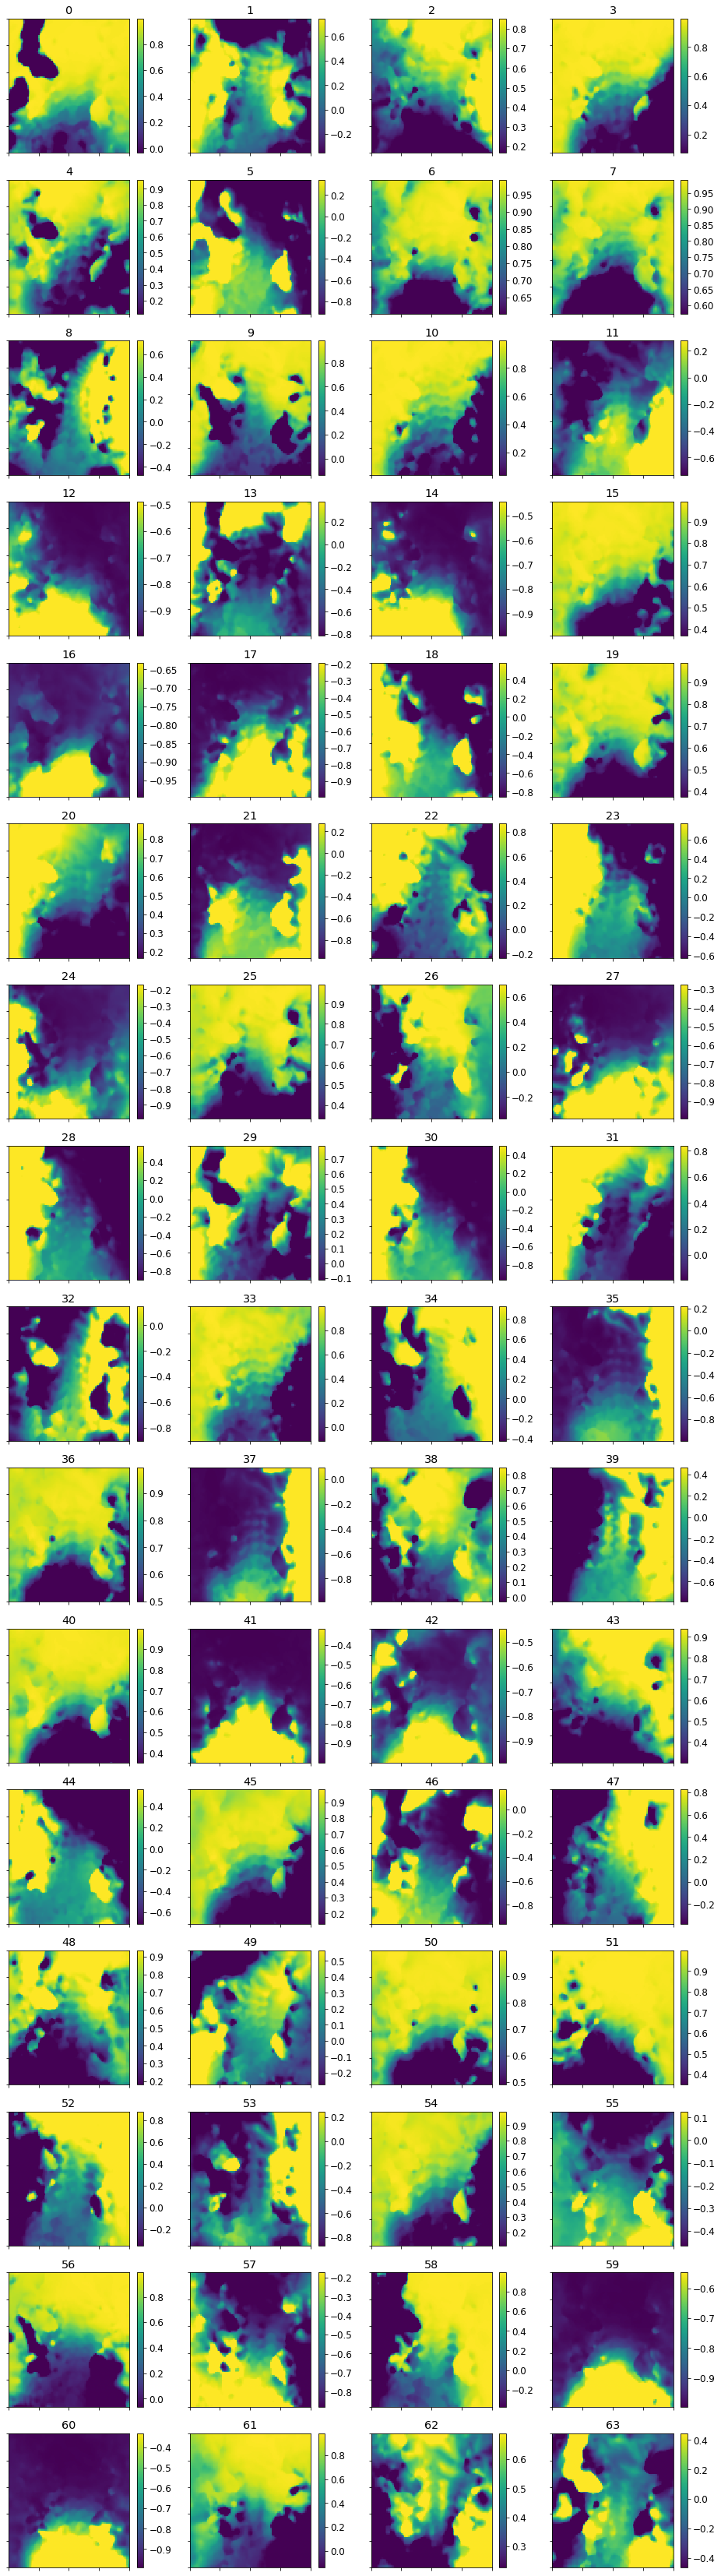

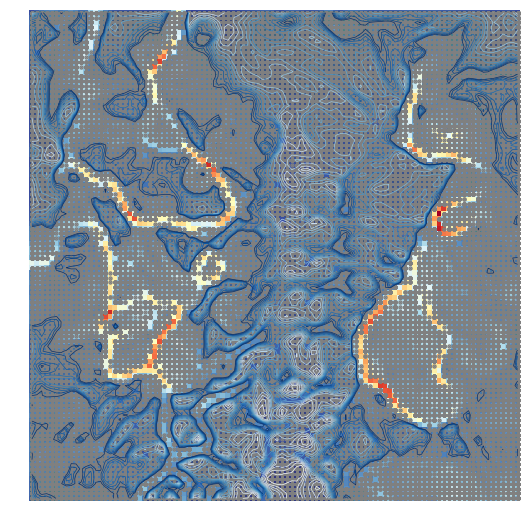

([], array([[0.20182087, 0.33003195, 0.46490824, ..., 0.25631307, 0.23484902,
         0.17308062],
        [0.34592432, 0.38697706, 0.43314404, ..., 0.28856044, 0.27626753,
         0.24500819],
        [0.43821007, 0.41557165, 0.40424158, ..., 0.30517615, 0.2979163 ,
         0.27108716],
        ...,
        [0.38252323, 0.47363182, 0.56758449, ..., 1.27331589, 1.23674985,
         1.1892916 ],
        [0.37508129, 0.45829278, 0.49950513, ..., 1.42268648, 1.37880615,
         1.23659259],
        [0.31218643, 0.40719165, 0.42934881, ..., 1.39358479, 1.34628264,
         0.99262866]]))

In [11]:
# U-matrix plot
from sompy.visualization.umatrix import UMatrixView

umat  = UMatrixView(width=10,height=10,title='U-matrix')
umat.show(sm)



In [12]:
# # do the K-means clustering on the SOM grid, sweep across k = 2 to 20
# from sompy.visualization.hitmap import HitMapView
# K = 20 # stop at this k for SSE sweep
# K_opt = 18 # optimal K already found
# _ = sm.cluster(K)
# hits  = HitMapView(20,20,"Clustering",text_size=12)
# a=hits.show(sm)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


 find_bmu took: 0.133000 seconds


['a_a', 'a_e', 'a_i', 'a_o', 'a_u', 'e_a', 'e_e', 'e_i', 'e_o', 'e_u', 'i_a', 'i_e', 'i_i', 'i_o', 'i_u', 'o_a', 'o_e', 'o_i', 'o_o', 'o_u', 'u_a', 'u_e', 'u_i', 'u_o', 'u_u']


 find_bmu took: 0.079000 seconds
 find_bmu took: 0.131000 seconds
 find_bmu took: 0.107000 seconds
 find_bmu took: 0.113000 seconds
 find_bmu took: 0.071000 seconds
 find_bmu took: 0.117000 seconds
 find_bmu took: 0.122000 seconds
 find_bmu took: 0.114000 seconds
 find_bmu took: 0.108000 seconds
 find_bmu took: 0.082000 seconds
 find_bmu took: 0.144000 seconds
 find_bmu took: 0.107000 seconds
 find_bmu took: 0.115000 seconds
 find_bmu took: 0.074000 seconds
 find_bmu took: 0.114000 seconds
 find_bmu took: 0.131000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.106000 seconds
 find_bmu took: 0.114000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.074000 seconds
 find_bmu took: 0.115000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.110000 seconds
 find_bmu took: 0.111000 seconds
 find_bmu 

 find_bmu took: 0.142000 seconds
 find_bmu took: 0.112000 seconds
 find_bmu took: 0.109000 seconds
 find_bmu took: 0.111000 seconds
 find_bmu took: 0.086000 seconds
 find_bmu took: 0.073000 seconds
 find_bmu took: 0.144000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.073000 seconds
 find_bmu took: 0.131000 seconds
 find_bmu took: 0.118000 seconds
 find_bmu took: 0.115000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.112000 seconds
 find_bmu took: 0.110000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.100000 seconds
 find_bmu took: 0.106000 seconds
 find_bmu took: 0.115000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.103000 seconds
 find_bmu took: 0.102000 seconds
 find_bmu took: 0.111000 seconds
 find_bmu took: 0.110000 seconds
 find_bmu took: 0.071000 seconds
 find_bmu took: 0.101000 seconds
 find_bmu took: 0.130000 seconds
 find_bmu 

 find_bmu took: 0.102000 seconds


1
1
1
1
1


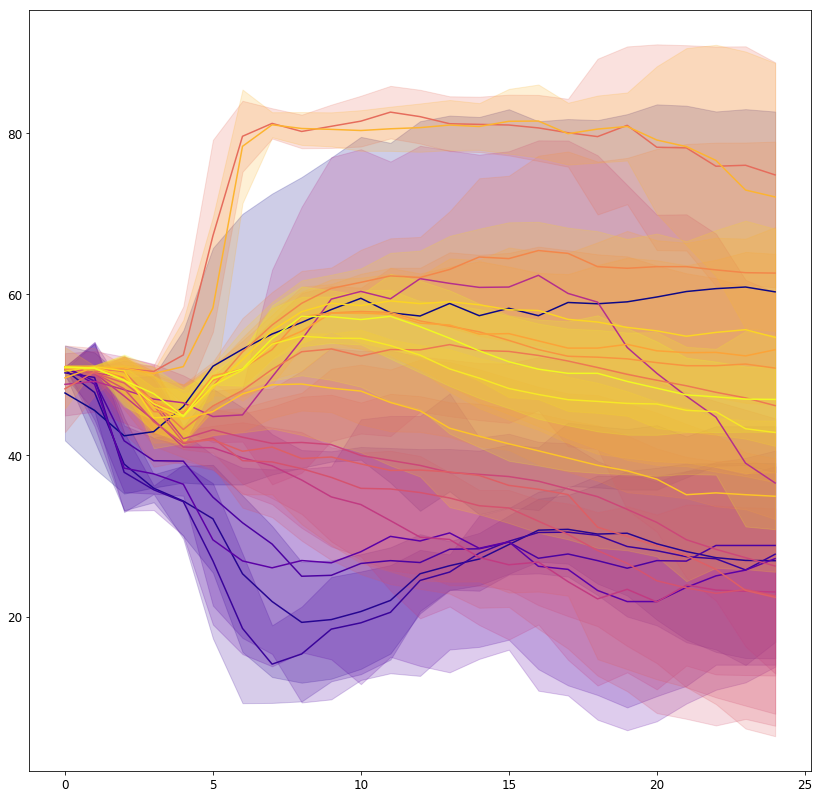

In [23]:
import matplotlib.pyplot as plt
import random
from collections import defaultdict

labels_unique = list(np.unique(labels))
print(labels_unique)
cmap = plt.get_cmap('plasma')
colors = [cmap(i) for i in np.linspace(0, 1, len(labels_unique))]

d = defaultdict(list)

plt.figure(figsize=(14,14))
for j in np.random.randint(0, 6000, 500):
#     print(j)
#     d[labels[j*25]
    sample = np.array(joined_data.iloc[j*25 :(j+1)*25].values)
    prj = sm.find_bmu(sample)
#     print(prj[0])
#     prj_1 = sm.project_data(sample)
#     print(prj_1)
#     bmus_xy = sm.bmu_ind_to_xy(prj_1)

    bmus_xy = sm.bmu_ind_to_xy(prj[0])
    d[labels[j*25]].append(bmus_xy)

    # [sm.bmu_ind_to_xy(p) for p in prj[0].reshape(-1,1)]
#     print(bmus_xy)
for l in labels_unique:
    if len(d[l]) == 0:
        print(1)
        continue
    xy = np.array(d[l])
    xy_mean = xy.mean(axis=0)
    xy_std = xy.std(axis=0)
    t = np.arange(0, 25, 1)
    plt.plot(t, xy_mean[:, 1], label=l, color=colors[labels_unique.index(l)])
    plt.fill_between(t, xy_mean[:, 1]-xy_std[:,1],  xy_mean[:, 1]+xy_std[:, 1], color=colors[labels_unique.index(l)], alpha=0.2)
# x, y, ind = zip(*bmus_xy)
# plt.plot(x, y, label=labels[j*25], color=colors[labels_unique.index(labels[j*25])], alpha=0.5 )

# # plt.legend()
plt.show()


# print(x)
# print(y)


In [20]:
t = np.arange(0, 25, 1)
print(t)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
